# Makueni Apiary Intelligence Notebook
This notebook links together geospatial selection, weather/NDVI retrieval, hive telemetry simulation, floral calendars, and machine learning models (including CNNs) to study hive health dynamics in Makueni County.

> Run the cells in order to regenerate each dataset.


In [1]:
import datetime
import os
import time
from pathlib import Path
import calendar
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests


## 1. Select Apiary Location on Map
Use the map widget to drag the pin or draw an enclosure; the coordinates feed the weather/NDVI fetch.


In [3]:
# Interactive map picker (OpenStreetMap) to capture coordinates
DEFAULT_CENTER = (-1.8048, 37.62)  # Makueni as fallback
lat_widget = lon_widget = geometry_widget = None
selected_geometry_geojson = None

try:
    import json
    import ipywidgets as widgets
    from ipyleaflet import Map, Marker, DrawControl, basemaps
except Exception:
    print("Install ipyleaflet + ipywidgets to enable the interactive map (pip install ipyleaflet ipywidgets).")
    print("Falling back to manual latitude/longitude values.")
else:
    lat_widget = widgets.FloatText(value=DEFAULT_CENTER[0], description="Latitude", step=0.0001)
    lon_widget = widgets.FloatText(value=DEFAULT_CENTER[1], description="Longitude", step=0.0001)
    geometry_widget = widgets.Textarea(
        value="",
        description="Geometry",
        placeholder="Draw a rectangle/polygon to capture an area (optional).",
        layout=widgets.Layout(width="100%", height="140px"),
        disabled=True,
    )

    leaflet_map = Map(
        center=DEFAULT_CENTER,
        zoom=8,
        basemap=basemaps.OpenStreetMap.Mapnik,
        scroll_wheel_zoom=True,
    )
    marker = Marker(location=DEFAULT_CENTER, draggable=True)
    leaflet_map.add_layer(marker)

    draw_control = DrawControl(
        polygon={"shapeOptions": {"color": "#2563eb", "weight": 2, "fillOpacity": 0.2}},
        rectangle={"shapeOptions": {"color": "#f97316", "weight": 2, "fillOpacity": 0.15}},
        circle={},
        circlemarker={},
        polyline={},
    )
    leaflet_map.add_control(draw_control)

    _sync_flags = {"marker": False, "widget": False}

    def _update_inputs(change):
        if _sync_flags["widget"]:
            return
        _sync_flags["marker"] = True
        lat, lon = change["new"]
        lat_widget.value = round(lat, 6)
        lon_widget.value = round(lon, 6)
        _sync_flags["marker"] = False

    marker.observe(_update_inputs, names=("location",))

    def _update_marker_from_lat(change):
        if _sync_flags["marker"]:
            return
        _sync_flags["widget"] = True
        marker.location = (change["new"], lon_widget.value)
        _sync_flags["widget"] = False

    def _update_marker_from_lon(change):
        if _sync_flags["marker"]:
            return
        _sync_flags["widget"] = True
        marker.location = (lat_widget.value, change["new"])
        _sync_flags["widget"] = False

    lat_widget.observe(_update_marker_from_lat, names="value")
    lon_widget.observe(_update_marker_from_lon, names="value")

    def _handle_draw(target, action, geo_json):
        global selected_geometry_geojson
        geometry = geo_json.get("geometry") if geo_json else None
        if not geometry:
            return
        selected_geometry_geojson = geometry
        geometry_widget.value = json.dumps(geometry, indent=2)
        coords = geometry.get("coordinates")
        if not coords:
            return
        if geometry["type"] == "Polygon" and isinstance(coords[0], list):
            ring = coords[0]
        elif geometry["type"] == "Point":
            ring = [coords]
        else:
            ring = coords[0] if isinstance(coords[0], list) else coords
        lats = [c[1] for c in ring]
        lons = [c[0] for c in ring]
        lat_widget.value = round(sum(lats) / len(lats), 6)
        lon_widget.value = round(sum(lons) / len(lons), 6)

    draw_control.on_draw(_handle_draw)

    picker_ui = widgets.VBox(
        [
            widgets.HTML("<b>Drag the pin or draw an area to fill the coordinates below.</b>"),
            widgets.HBox([lat_widget, lon_widget]),
            geometry_widget,
            leaflet_map,
        ]
    )
    display(picker_ui)



In [4]:
if 'DEFAULT_CENTER' not in globals():
    DEFAULT_CENTER = (-1.8048, 37.62)

lat_widget_available = 'lat_widget' in globals() and lat_widget is not None
lon_widget_available = 'lon_widget' in globals() and lon_widget is not None

if lat_widget_available and lon_widget_available:
    latitude = float(lat_widget.value)
    longitude = float(lon_widget.value)
else:
    latitude, longitude = DEFAULT_CENTER
    print('Interactive map not available, using default coordinates.')

selected_geometry = globals().get('selected_geometry_geojson')
if selected_geometry:
    geom_type = selected_geometry.get('type', 'geometry')
    print(f"Selected area geometry: {geom_type}")
else:
    print('No area selected; using point coordinates only.')

raw_start_date = "2008-01-01"
raw_end_date   = "2025-12-05"
timezone = "Africa/Nairobi"
output_csv = "./content/main-data/makueni_weather_2008_2025.csv"



No area selected; using point coordinates only.


## 2. Configure Time Range & Download Weather
Normalize date inputs, split into API-friendly chunks, and pull historical weather from Open-Meteo.


In [5]:
def normalize_date_string(d: str) -> datetime.date:
    """Convert a string to a date; if day is invalid (e.g. 2025-09-31), clamp to last day of that month."""
    parts = d.split("-")
    if len(parts) != 3:
        raise ValueError("Date must be YYYY-MM-DD")
    y, m, day = int(parts[0]), int(parts[1]), int(parts[2])
    # clamp month -> 1..12
    m = max(1, min(12, m))
    # find last day of month
    last_day = calendar.monthrange(y, m)[1]
    day = max(1, min(last_day, day))
    return datetime.date(y, m, day)

start_date = normalize_date_string(raw_start_date)
end_date   = normalize_date_string(raw_end_date)

today = datetime.date.today()

api_latest = datetime.date(2025, 12, 20)
max_allowed = min(today, api_latest)

if end_date > max_allowed:
    print(f"end_date {end_date} is after API max {max_allowed}. Clamping to {max_allowed}.")
    end_date = max_allowed

if start_date < datetime.date(1940, 1, 1):
    print("start_date is before 1940-01-01 — clamping to 1940-01-01")
    start_date = datetime.date(1940, 1, 1)

if start_date > end_date:
    raise ValueError(f"start_date {start_date} is after end_date {end_date}")

print("Using date range:", start_date, "→", end_date)


Using date range: 2008-01-01 → 2025-12-05


In [6]:
def split_date_range(start: datetime.date, end: datetime.date, max_days: int = 365) -> List[Tuple[datetime.date, datetime.date]]:
    chunks = []
    current_start = start
    while current_start <= end:
        current_end = min(end, current_start + datetime.timedelta(days=max_days-1))
        chunks.append((current_start, current_end))
        current_start = current_end + datetime.timedelta(days=1)
    return chunks

chunks = split_date_range(start_date, end_date, max_days=365)
print("Will fetch in", len(chunks), "chunk(s):", chunks)


Will fetch in 18 chunk(s): [(datetime.date(2008, 1, 1), datetime.date(2008, 12, 30)), (datetime.date(2008, 12, 31), datetime.date(2009, 12, 30)), (datetime.date(2009, 12, 31), datetime.date(2010, 12, 30)), (datetime.date(2010, 12, 31), datetime.date(2011, 12, 30)), (datetime.date(2011, 12, 31), datetime.date(2012, 12, 29)), (datetime.date(2012, 12, 30), datetime.date(2013, 12, 29)), (datetime.date(2013, 12, 30), datetime.date(2014, 12, 29)), (datetime.date(2014, 12, 30), datetime.date(2015, 12, 29)), (datetime.date(2015, 12, 30), datetime.date(2016, 12, 28)), (datetime.date(2016, 12, 29), datetime.date(2017, 12, 28)), (datetime.date(2017, 12, 29), datetime.date(2018, 12, 28)), (datetime.date(2018, 12, 29), datetime.date(2019, 12, 28)), (datetime.date(2019, 12, 29), datetime.date(2020, 12, 27)), (datetime.date(2020, 12, 28), datetime.date(2021, 12, 27)), (datetime.date(2021, 12, 28), datetime.date(2022, 12, 27)), (datetime.date(2022, 12, 28), datetime.date(2023, 12, 27)), (datetime.date

In [7]:
def fetch_chunk(lat, lon, sdate: datetime.date, edate: datetime.date, timezone="Africa/Nairobi", max_retries=3, backoff=2):
    base = "https://archive-api.open-meteo.com/v1/archive"
    daily_vars = ",".join([
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "relative_humidity_2m_mean",
        "wind_speed_10m_max",
        "cloudcover_mean"
    ])
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": sdate.strftime("%Y-%m-%d"),
        "end_date":   edate.strftime("%Y-%m-%d"),
        "daily": daily_vars,
        "timezone": timezone
    }
    for attempt in range(1, max_retries+1):
        try:
            r = requests.get(base, params=params, timeout=30)
            r.raise_for_status()
            payload = r.json()
            # Basic validation
            if "daily" not in payload or "time" not in payload["daily"]:
                raise ValueError("API response missing expected daily/time fields.")
            return payload
        except Exception as e:
            print(f"Attempt {attempt} failed: {e}")
            if attempt == max_retries:
                raise
            time.sleep(backoff ** attempt)

In [8]:
#all chunks and assemble into a single DataFrame
dfs = []
for s, e in chunks:
    print("Fetching", s, "→", e)
    payload = fetch_chunk(latitude, longitude, s, e, timezone=timezone)
    daily = payload["daily"]
    df_chunk = pd.DataFrame({
        "date": daily["time"],
        "temp_max": daily.get("temperature_2m_max"),
        "temp_min": daily.get("temperature_2m_min"),
        "temp_mean": daily.get("temperature_2m_mean"),
        "humidity_mean": daily.get("relative_humidity_2m_mean"),
        "rainfall_mm": daily.get("precipitation_sum"),
        "wind_speed_max": daily.get("wind_speed_10m_max"),
        "cloud_cover_percent": daily.get("cloudcover_mean"),
    })
    dfs.append(df_chunk)
    # polite pause (avoid rate-limits)
    time.sleep(1)

# concatenate & convert date column
df = pd.concat(dfs, ignore_index=True)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
print("Total rows:", df.shape[0])
df.head()

Fetching 2008-01-01 → 2008-12-30
Fetching 2008-12-31 → 2009-12-30
Fetching 2009-12-31 → 2010-12-30
Fetching 2010-12-31 → 2011-12-30
Fetching 2011-12-31 → 2012-12-29
Fetching 2012-12-30 → 2013-12-29
Fetching 2013-12-30 → 2014-12-29
Fetching 2014-12-30 → 2015-12-29
Fetching 2015-12-30 → 2016-12-28
Fetching 2016-12-29 → 2017-12-28
Fetching 2017-12-29 → 2018-12-28
Fetching 2018-12-29 → 2019-12-28
Fetching 2019-12-29 → 2020-12-27
Fetching 2020-12-28 → 2021-12-27
Fetching 2021-12-28 → 2022-12-27
Fetching 2022-12-28 → 2023-12-27
Fetching 2023-12-28 → 2024-12-26
Fetching 2024-12-27 → 2025-12-05
Total rows: 6549


,date,temp_max,temp_min,temp_mean,humidity_mean,rainfall_mm,wind_speed_max,cloud_cover_percent
0,2008-01-01,24.9,16.4,20.3,74,1.2,15.1,53
1,2008-01-02,25.8,14.1,20.2,71,0.8,14.3,19
2,2008-01-03,27.2,15.2,21.3,65,0.0,12.8,11
3,2008-01-04,27.6,15.4,22.2,63,0.1,12.2,26
4,2008-01-05,27.3,15.2,21.0,75,2.9,13.1,58


In [9]:
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 6549 non-null   datetime64[ns]
 1   temp_max             6549 non-null   float64       
 2   temp_min             6549 non-null   float64       
 3   temp_mean            6549 non-null   float64       
 4   humidity_mean        6549 non-null   int64         
 5   rainfall_mm          6549 non-null   float64       
 6   wind_speed_max       6549 non-null   float64       
 7   cloud_cover_percent  6549 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 409.4 KB
None
                      date     temp_max     temp_min    temp_mean  \
count                 6549  6549.000000  6549.000000  6549.000000   
mean   2016-12-18 00:00:00    26.386929    16.268117    20.891144   
min    2008-01-01 00:00:00    18.800000  

Saved CSV: ./content/main-data/makueni_weather_2008_2025.csv


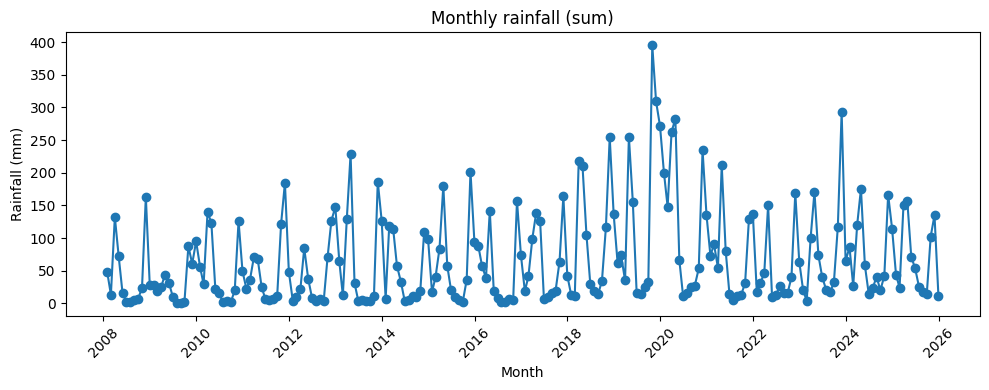

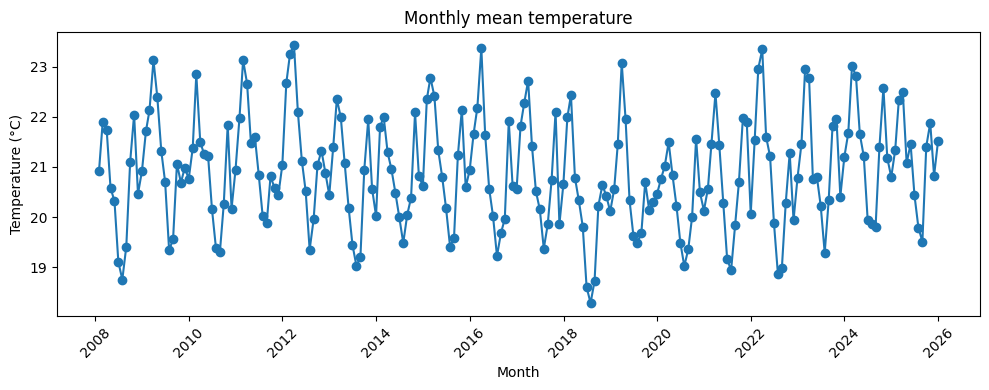

In [10]:
df.to_csv(output_csv, index=False)
print("Saved CSV:", output_csv)

#monthly rainfall and monthly mean temperature
df_month = df.set_index("date").resample("ME").agg({
    "rainfall_mm": "sum",
    "temp_mean": "mean",
    "humidity_mean": "mean"
}).reset_index()

#rainfall 
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_month["date"], df_month["rainfall_mm"], marker='o')
ax.set_title("Monthly rainfall (sum)")
ax.set_xlabel("Month")
ax.set_ylabel("Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#monthly mean temperature
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_month["date"], df_month["temp_mean"], marker='o')
ax.set_title("Monthly mean temperature")
ax.set_xlabel("Month")
ax.set_ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Vegetation Indices via Google Earth Engine
Authenticate with Earth Engine once, then fetch MODIS NDVI for the selected point.


In [12]:
import ee

try:
    ee.Initialize()
    print('Earth Engine initialized.')
except Exception:
    print('Authenticating with Earth Engine...')
    ee.Authenticate()
    ee.Initialize()
    print('Earth Engine initialized.')


Authenticating with Earth Engine...



Successfully saved authorization token.
Earth Engine initialized.


In [13]:
import pandas as pd
point = ee.Geometry.Point([37.6200, -1.8048])
modis = ee.ImageCollection("MODIS/061/MOD13Q1") \
            .select('NDVI') \
            .filterDate('2008-01-01', '2025-09-30') \
            .filterBounds(point)
def extract_ndvi(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=250
    ).get('NDVI')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {
        'date': date,
        'ndvi_mean': mean
    })
ndvi_fc = modis.map(extract_ndvi).getInfo()
records = [f['properties'] for f in ndvi_fc['features']]
df_ndvi = pd.DataFrame(records)
df_ndvi['ndvi_mean'] = df_ndvi['ndvi_mean'].astype(float) / 10000
# Save to CSV
df_ndvi.to_csv("./content/main-data/makueni_ndvi_2008_2025.csv", index=False)
df_ndvi.head(), df_ndvi.shape


(         date  ndvi_mean
 0  2008-01-01     0.6805
 1  2008-01-17     0.6490
 2  2008-02-02     0.6585
 3  2008-02-18     0.4515
 4  2008-03-05     0.4682,
 (408, 2))

In [14]:
import pandas as pd

#Loading both datasets
df_weather = pd.read_csv("content/main-data/makueni_weather_2008_2025.csv")
df_ndvi = pd.read_csv("content/main-data/makueni_ndvi_2008_2025.csv")

#Convert to datetime to avoid merge issues
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])

#Merge by date
df_merged = pd.merge(df_weather, df_ndvi, on='date', how='left')

#Sort by date
df_merged = df_merged.sort_values(by='date')

#Save final combined dataset
output_path = "./content/main-data/makueni_weather_ndvi_2008_2025.csv"
df_merged.to_csv(output_path, index=False)

df_merged.head(), df_merged.shape


(        date  temp_max  temp_min  temp_mean  humidity_mean  rainfall_mm  \
 0 2008-01-01      24.9      16.4       20.3             74          1.2   
 1 2008-01-02      25.8      14.1       20.2             71          0.8   
 2 2008-01-03      27.2      15.2       21.3             65          0.0   
 3 2008-01-04      27.6      15.4       22.2             63          0.1   
 4 2008-01-05      27.3      15.2       21.0             75          2.9   
 
    wind_speed_max  cloud_cover_percent  ndvi_mean  
 0            15.1                   53     0.6805  
 1            14.3                   19        NaN  
 2            12.8                   11        NaN  
 3            12.2                   26        NaN  
 4            13.1                   58        NaN  ,
 (6549, 9))

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("content/main-data/makueni_weather_ndvi_2008_2025.csv")

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,temp_max,temp_min,temp_mean,humidity_mean,rainfall_mm,wind_speed_max,cloud_cover_percent,ndvi_mean
0,2008-01-01,24.9,16.4,20.3,74,1.2,15.1,53,0.6805
1,2008-01-02,25.8,14.1,20.2,71,0.8,14.3,19,NaN
2,2008-01-03,27.2,15.2,21.3,65,0.0,12.8,11,NaN
3,2008-01-04,27.6,15.4,22.2,63,0.1,12.2,26,NaN
4,2008-01-05,27.3,15.2,21.0,75,2.9,13.1,58,NaN


## 4. Simulate Hive Telemetry & Floral Calendar
Create weekly hive metrics (yield, pests, feeding) and compile a literature-based flowering calendar.


In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import os

out_dir = "."
os.makedirs(out_dir, exist_ok=True)

start_date = "2008-01-01"
end_date = "2025-09-30"
freq = "7D"  # weekly sampling

hive_ids = ["Hive-A", "Hive-B", "Hive-C", "Hive-D"]

#queen ages in months
queen_age_start = {
    "Hive-A": 8,   
    "Hive-B": 15,
    "Hive-C": 4,
    "Hive-D": 20
}

# Seed for reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
QUEEN_RESET_MONTHS = 24

start_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_dt = datetime.strptime(end_date, "%Y-%m-%d")
base_year = start_dt.year
base_month = start_dt.month

# Helper to compute months elapsed since the configured start date
def months_elapsed(date_obj):
    return (date_obj.year - base_year) * 12 + (date_obj.month - base_month)

# Create weekly dates
dates = pd.date_range(start=start_dt, end=end_dt, freq=freq)

rows = []
for d in dates:
    m_elapsed = months_elapsed(d)
    month = d.month

# Seasonal modulation: create simple month-based multipliers for nectar
# typical avocado/mango/prosopis/flowering seasons referenced in literature for Kenya.
# Jan-Mar: some flowering (multiplier 1.0)
# Apr-Jun: dry season/less forage in some areas (0.9)
# Jul-Aug: minor flowering (1.05)
# Sep: avocado/mango flowering peaks in some regions (1.2)
    if month in [1,2,3]:
        season_mul = 1.00
    elif month in [4,5,6]:
        season_mul = 0.90
    elif month in [7,8]:
        season_mul = 1.05
    elif month == 9:
        season_mul = 1.20
    else:
        season_mul = 1.00

    for h in hive_ids:
# Base parameters per hive
        base_yield = {"Hive-A": 2.8, "Hive-B": 3.2, "Hive-C": 2.2, "Hive-D": 3.0}[h]
        base_colony = {"Hive-A": 30000, "Hive-B": 42000, "Hive-C": 25000, "Hive-D": 48000}[h]
        base_brood = {"Hive-A": 1500, "Hive-B": 2000, "Hive-C": 1200, "Hive-D": 2100}[h]
        base_weight = {"Hive-A": 33, "Hive-B": 36, "Hive-C": 30, "Hive-D": 38}[h]

# Honey yield (kg) for the week: seasonal * base + random noise.
# Ensures yields are non-negative.
        noise = rng.normal(0, 0.9)
        honey_yield_kg = max(0.0, round(base_yield * season_mul + noise, 2))

# Colony size
        colony_size = int(max(6000, base_colony + rng.integers(-5000, 8000)))

# Brood area in cm^2
        brood_area_cm2 = int(max(300, base_brood + rng.integers(-500, 800)))

# Queen age progression in months
        queen_age_months = queen_age_start[h] + m_elapsed
        if queen_age_months > QUEEN_RESET_MONTHS:
            queen_age_months = ((queen_age_months - 1) % QUEEN_RESET_MONTHS) + 1

 # Varroa infestation percent
        # (varroa often increases with brood availability; we'll tie to brood area)
        varroa_base = 1.5 + (brood_area_cm2 / 3000.0)  # this gives ~1.5 - 2.5 range
        # Add random noise, and cap at 20%
        varroa_pct = round(min(20.0, abs(rng.normal(varroa_base, 1.2))), 2)

# Nosema presence (0/1): random but slightly more likely in wetter months (Apr-Jun)
        nosema_prob = 0.06
        if month in [4,5,6]:
            nosema_prob = 0.12
        nosema_present = int(rng.random() < nosema_prob)

# American foulbrood presence rare
        afb_prob = 0.015
        afb_present = int(rng.random() < afb_prob)

# Small hive beetle count: more likely in warm/wet months
        if month in [3,4,5,11,12]:
            shb_count = int(max(0, rng.integers(0, 8)))
        else:
            shb_count = int(max(0, rng.integers(0, 3)))

# Hive weight (kg) approximate current weight with some noise
        hive_weight_kg = round(base_weight + rng.normal(0, 3), 2)

# Feeding done (0/1)more feeding in dry months (Apr-Jun)
        feed_prob = 0.08
        if month in [4,5,6]:
            feed_prob = 0.25
        feeding_done = int(rng.random() < feed_prob)
#Stress levels
        stress = "none"
        if varroa_pct > 7.0 and rng.random() < 0.6:
            stress = "pest_pressure"
        elif nosema_present and rng.random() < 0.5:
            stress = "disease_outbreak"
        elif feeding_done == 1 and season_mul < 1.0 and rng.random() < 0.3:
            stress = "drought_stress"
        elif rng.random() < 0.02:
            stress = "queen_failure"

        note = ""
        if stress != "none":
            note = f"{stress}; varroa={varroa_pct}%; shb={shb_count}"

        rows.append({
            "date": d.strftime("%Y-%m-%d"),
            "hive_id": h,
            "honey_yield_kg": honey_yield_kg,
            "colony_size": colony_size,
            "brood_area_cm2": brood_area_cm2,
            "queen_age_months": queen_age_months,
            "varroa_pct": varroa_pct,
            "nosema_present": nosema_present,
            "afb_present": afb_present,
            "shb_count": shb_count,
            "hive_weight_kg": hive_weight_kg,
            "feeding_done": feeding_done,
            "stress_event": stress,
            "note": note
        })

# Save hive logs CSV
hive_df = pd.DataFrame(rows)
hive_csv_path = os.path.join(out_dir, "./content/main-data/hive_logs_2008_2025.csv")
hive_df.to_csv(hive_csv_path, index=False)
print("Saved:", hive_csv_path)
print(hive_df.head())

#A simple floral calendar for Makueni
#The months are integers 1..12 mark typical months where the species flowers in Kenya/Makueni region.
#Sources: KEPHIS, avocado flowering studies in Kenya, local agriculture pages, ethnobotanical literature
floral_calendar = [
    {"species": "Avocado (Persea americana)", "common_name": "Avocado", "flowering_months": "2-5,8-10", 
     "notes": "Two flowering seasons observed in Kenya: Feb–May and Aug–Oct (peak months include Mar & Sep)."},
    {"species": "Mango (Mangifera indica)", "common_name": "Mango", "flowering_months": "9-12",
     "notes": "Main mango seasons in Makueni typically peak around Oct–Dec (regional variation)."},
    {"species": "Prosopis juliflora (Prosopis)", "common_name": "Prosopis", "flowering_months": "1-4",
     "notes": "Invasive species; provides nectar/pollen in some dryland areas."},
    {"species": "Acacia spp. (e.g., Acacia mellifera)", "common_name": "Acacia", "flowering_months": "6-10",
     "notes": "Various acacia species flower at different times; important dryland nectar sources."},
    {"species": "Dombeya torrida", "common_name": "Dombeya", "flowering_months": "9-11",
     "notes": "Reported as an important melliferous species in East Africa."},
    {"species": "Grevillea robusta", "common_name": "Grevillea", "flowering_months": "1-3,8-10",
     "notes": "Common agroforestry tree used as windbreaks; nectar source."},
    {"species": "Maize (Flowering maize as pollen source)", "common_name": "Maize", "flowering_months": "10-12",
     "notes": "Flowering maize supplies pollen rather than nectar; seasonal with cropping calendars."},
]

floral_df = pd.DataFrame(floral_calendar)
floral_csv_path = os.path.join(out_dir, "./content/main-data/floral_calendar_makueni.csv")
floral_df.to_csv(floral_csv_path, index=False)
print("Saved floral calendar:", floral_csv_path)

Saved: ././content/main-data/hive_logs_2008_2025.csv
         date hive_id  honey_yield_kg  colony_size  brood_area_cm2  \
0  2008-01-01  Hive-A            3.07        33509            1570   
1  2008-01-01  Hive-B            2.43        49683            2150   
2  2008-01-01  Hive-C            1.34        31157            1775   
3  2008-01-01  Hive-D            3.48        55619            2247   
4  2008-01-08  Hive-A            3.35        35343            1246   

   queen_age_months  varroa_pct  nosema_present  afb_present  shb_count  \
0                 8        2.92               0            0          1   
1                15        3.15               0            0          1   
2                 4        2.03               0            0          0   
3                20        2.74               0            0          0   
4                 8        1.78               0            0          1   

   hive_weight_kg  feeding_done stress_event note  
0           33.38      

In [18]:
import pandas as pd

# Load datasets
hive = pd.read_csv("content/main-data/hive_logs_2008_2025.csv")
weather = pd.read_csv("content/main-data/makueni_weather_ndvi_2008_2025.csv")

# Convert dates to datetime
hive["date"] = pd.to_datetime(hive["date"])
weather["date"] = pd.to_datetime(weather["date"])

# Merge hive + weather
merged = pd.merge(hive, weather, on="date", how="left")

# Save
merged.to_csv("./content/main-data/merged_hive_weather_2008_2025.csv", index=False)

merged.head()
merged.describe()


,date,honey_yield_kg,colony_size,brood_area_cm2,queen_age_months,varroa_pct,nosema_present,afb_present,shb_count,hive_weight_kg,feeding_done,temp_max,temp_min,temp_mean,humidity_mean,rainfall_mm,wind_speed_max,cloud_cover_percent,ndvi_mean
count,3708,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,236.000000
mean,2016-11-15 00:00:00,2.820655,37728.827940,1848.583873,12.534250,2.167996,0.074434,0.015102,2.078479,34.232389,0.126483,26.396656,16.264833,20.889752,68.417476,2.074649,13.629773,67.373247,0.527129
min,2008-01-01 00:00:00,0.000000,20012.000000,700.000000,1.000000,0.000000,0.000000,0.000000,0.000000,21.680000,0.000000,20.600000,10.700000,17.500000,38.000000,0.000000,5.800000,0.000000,0.236700
25%,2012-06-05 00:00:00,2.120000,28718.750000,1504.750000,7.000000,1.320000,0.000000,0.000000,1.000000,31.057500,0.000000,25.000000,15.200000,19.900000,61.000000,0.000000,12.100000,54.000000,0.365200
50%,2016-11-15 00:00:00,2.820000,37624.000000,1849.500000,13.000000,2.140000,0.000000,0.000000,2.000000,34.275000,0.000000,26.200000,16.500000,20.800000,68.000000,0.400000,13.500000,69.000000,0.572800
75%,2021-04-27 00:00:00,3.490000,46554.250000,2222.000000,19.000000,2.920000,0.000000,0.000000,3.000000,37.340000,0.000000,27.900000,17.500000,21.800000,75.000000,2.300000,15.300000,85.000000,0.662000
max,2025-09-30 00:00:00,6.150000,55988.000000,2898.000000,24.000000,5.760000,1.000000,1.000000,7.000000,47.810000,1.000000,32.100000,19.600000,24.700000,92.000000,50.500000,23.900000,100.000000,0.759900
std,NaN,1.011648,10033.457497,520.656967,6.925996,1.140506,0.262511,0.121977,2.043905,4.345396,0.332438,2.067243,1.585752,1.319813,9.694188,4.125341,2.525215,21.544087,0.154819


In [19]:
import pandas as pd

# Floral calendar Jan–Sep 2025
data = {
    "date": [
        "2025-01-15","2025-02-15","2025-03-15","2025-04-15",
        "2025-05-15","2025-06-15","2025-07-15","2025-08-15","2025-09-15"
    ],
    "major_flowers": [
        "Acacia tortilis, Mango, Commiphora",
        "Acacia tortilis, Acacia mellifera, Mango",
        "Croton, Acacia mellifera",
        "Croton, Melia volkensii",
        "Citrus, Croton",
        "Aloe, Citrus",
        "Aloe, Pasture weeds",
        "Eucalyptus, Pasture weeds",
        "Eucalyptus camaldulensis"
    ],
    "nectar_flow_strength": [
        "High","High","Medium","Medium","Medium","Medium","Low","Low-Medium","High"
    ],
    "stress_risk": [
        "Low","Low","Medium","Low","Medium","Medium","High","High","Low"
    ],
    "pest_disease_notes": [
        "Hive beetles active",
        "Wax moth pressure",
        "Varroa buildup",
        "Chalkbrood risk",
        "Nosema risk",
        "Slow brood buildup",
        "Ant invasions",
        "Weak colony pests",
        "Healthy buildup"
    ]
}

floral = pd.DataFrame(data)
floral["date"] = pd.to_datetime(floral["date"])
floral


,date,major_flowers,nectar_flow_strength,stress_risk,pest_disease_notes
0,2025-01-15,"Acacia tortilis, Mango, Commiphora",High,Low,Hive beetles active
1,2025-02-15,"Acacia tortilis, Acacia mellifera, Mango",High,Low,Wax moth pressure
2,2025-03-15,"Croton, Acacia mellifera",Medium,Medium,Varroa buildup
3,2025-04-15,"Croton, Melia volkensii",Medium,Low,Chalkbrood risk
4,2025-05-15,"Citrus, Croton",Medium,Medium,Nosema risk
5,2025-06-15,"Aloe, Citrus",Medium,Medium,Slow brood buildup
6,2025-07-15,"Aloe, Pasture weeds",Low,High,Ant invasions
7,2025-08-15,"Eucalyptus, Pasture weeds",Low-Medium,High,Weak colony pests
8,2025-09-15,Eucalyptus camaldulensis,High,Low,Healthy buildup


## 5. Merge Hive, Weather, and Floral Data
Align the generated datasets on the date index for downstream modeling.


In [20]:
merged = (
    hive
    .merge(weather, on="date", how="left")
    .merge(floral, on="date", how="left")
)

merged.to_csv("./content/main-data/merged_hive_weather_floral_2025.csv", index=False)

In [21]:
floral.to_csv("./content/main-data/makueni_floral_calendar_2025.csv", index=False)

print("Floral calendar saved as 'makueni_floral_calendar_2025.csv'")

Floral calendar saved as 'makueni_floral_calendar_2025.csv'


## Hive Health Modeling with Acoustic Intelligence
We now fuse hive logs, weather/NDVI histories, and (optionally) the acoustic predictions logged by the FastAPI service to train a consolidated stress-detection model.


In [22]:
import json
from pathlib import Path
import pandas as pd

data_dir = Path("content/main-data")
hive_path = data_dir / "hive_logs_2008_2025.csv"
weather_path = data_dir / "makueni_weather_ndvi_2008_2025.csv"
acoustic_path = data_dir / "acoustic_predictions.csv"

hive_df = pd.read_csv(hive_path, parse_dates=["date"])
weather_df = pd.read_csv(weather_path, parse_dates=["date"])
hive_df.sort_values(["hive_id", "date"], inplace=True)
weather_df.sort_values("date", inplace=True)

acoustic_df = None
if acoustic_path.exists():
    tmp = pd.read_csv(acoustic_path)
    if not tmp.empty:
        for col in ("recorded_at", "created_at"):
            if col in tmp.columns:
                tmp[col] = pd.to_datetime(tmp[col], errors="coerce")
        tmp["date"] = (
            tmp.get("recorded_at")
            .fillna(tmp.get("created_at"))
            .dt.tz_localize(None)
            .dt.date
        )
        tmp.dropna(subset=["date"], inplace=True)
        tmp["date"] = pd.to_datetime(tmp["date"])
        if "probabilities_json" in tmp.columns:
            prob_df = (
                tmp["probabilities_json"].fillna("{}").apply(json.loads)
            )
            prob_df = pd.json_normalize(prob_df).add_prefix("acoustic_prob_")
            tmp = pd.concat([tmp, prob_df], axis=1)
        tmp.sort_values(["hive_id", "date", "created_at"], inplace=True)
        acoustic_df = tmp.groupby(["hive_id", "date"], as_index=False).last()
    else:
        print("Acoustic log exists but is empty; skipping acoustic merge.")
else:
    print("Acoustic log not found; continuing with hive + weather data only.")

merged_df = hive_df.merge(weather_df, on="date", how="left")
if acoustic_df is not None:
    merged_df = merged_df.merge(
        acoustic_df.drop(columns=[col for col in ["audio_filename"] if col in acoustic_df]),
        on=["hive_id", "date"],
        how="left"
    )

merged_df.sort_values(["hive_id", "date"], inplace=True)
merged_df.head()


,date,hive_id,honey_yield_kg,colony_size,brood_area_cm2,queen_age_months,varroa_pct,nosema_present,afb_present,shb_count,...,created_at,recorded_at,latitude,longitude,predicted_label,confidence,probabilities_json,acoustic_prob_absent,acoustic_prob_external,acoustic_prob_present
0,2008-01-01,Hive-A,3.07,33509,1570,8,2.92,0,0,1,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-08,Hive-A,3.35,35343,1246,8,1.78,0,0,1,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-15,Hive-A,2.49,29517,1567,8,3.05,0,0,0,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-22,Hive-A,2.46,34934,2259,8,1.83,0,0,2,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-29,Hive-A,1.48,30436,1626,8,2.42,0,0,2,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
import numpy as np

model_df = merged_df.copy()
model_df["stress_event"] = model_df["stress_event"].fillna("none")
model_df["stress_target"] = (model_df["stress_event"] != "none").astype(int)
model_df["month"] = model_df["date"].dt.month
model_df["year"] = model_df["date"].dt.year
model_df["weekofyear"] = model_df["date"].dt.isocalendar().week.astype(int)

rolling_features = ["honey_yield_kg", "varroa_pct", "hive_weight_kg", "brood_area_cm2"]
for feature in rolling_features:
    if feature in model_df.columns:
        model_df[f"{feature}_rolling_mean"] = (
            model_df.groupby("hive_id")[feature]
            .transform(lambda s: s.rolling(window=4, min_periods=1).mean())
        )
        model_df[f"{feature}_rolling_std"] = (
            model_df.groupby("hive_id")[feature]
            .transform(lambda s: s.rolling(window=4, min_periods=1).std())
        )

model_df.head()



,date,hive_id,honey_yield_kg,colony_size,brood_area_cm2,queen_age_months,varroa_pct,nosema_present,afb_present,shb_count,...,year,weekofyear,honey_yield_kg_rolling_mean,honey_yield_kg_rolling_std,varroa_pct_rolling_mean,varroa_pct_rolling_std,hive_weight_kg_rolling_mean,hive_weight_kg_rolling_std,brood_area_cm2_rolling_mean,brood_area_cm2_rolling_std
0,2008-01-01,Hive-A,3.07,33509,1570,8,2.92,0,0,1,...,2008,1,3.0700,NaN,2.920000,NaN,33.380,NaN,1570.0,NaN
1,2008-01-08,Hive-A,3.35,35343,1246,8,1.78,0,0,1,...,2008,2,3.2100,0.197990,2.350000,0.806102,34.305,1.308148,1408.0,229.102597
2,2008-01-15,Hive-A,2.49,29517,1567,8,3.05,0,0,0,...,2008,3,2.9700,0.438634,2.583333,0.698737,32.950,2.522638,1461.0,186.201504
3,2008-01-22,Hive-A,2.46,34934,2259,8,1.83,0,0,2,...,2008,4,2.8425,0.439649,2.395000,0.683642,32.250,2.490475,1660.5,426.983606
4,2008-01-29,Hive-A,1.48,30436,1626,8,2.42,0,0,2,...,2008,5,2.4450,0.764308,2.270000,0.595707,32.465,2.652401,1674.5,423.934350


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       685
           1       0.62      0.54      0.58        57

    accuracy                           0.94       742
   macro avg       0.79      0.76      0.77       742
weighted avg       0.94      0.94      0.94       742

ROC AUC: 0.8866692278140607


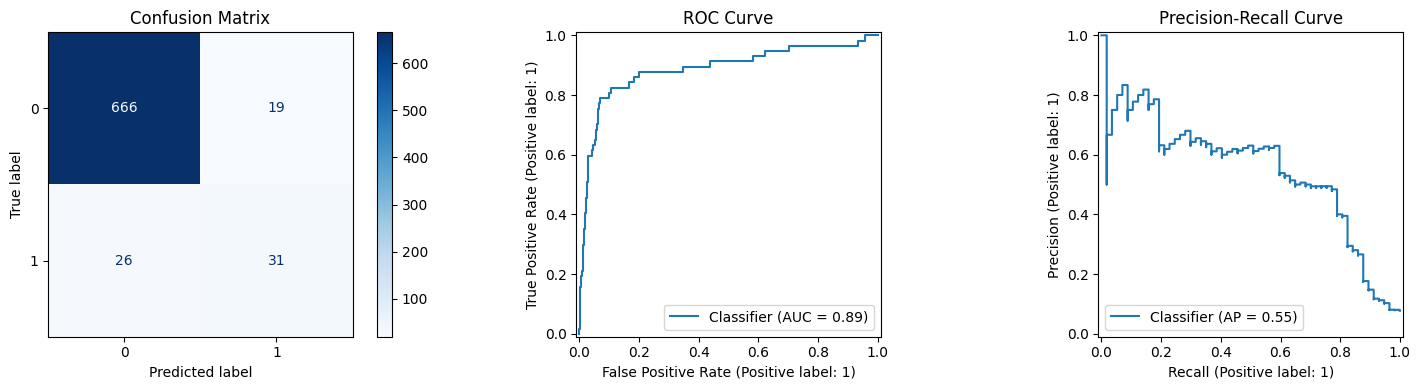

Saved unified model to content/main-data/hive_unified_model.pkl


In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import joblib

numeric_cols = model_df.select_dtypes(include=[np.number]).columns
exclude_cols = {"stress_target", "created_at", "recorded_at"}
feature_cols = [col for col in numeric_cols if col not in exclude_cols]
X = model_df[feature_cols].copy()
X = X.dropna(axis=1, how="all")
feature_cols = list(X.columns)

imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(
    imputer.fit_transform(X),
    columns=feature_cols,
    index=model_df.index,
)
y = model_df["stress_target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

hb_model = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.08,
    max_iter=400,
    min_samples_leaf=30,
    class_weight=class_weight_dict,
    random_state=42,
)
hb_model.fit(X_train, y_train)

y_pred = hb_model.predict(X_test)
y_prob = hb_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix")
RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[1])
axes[1].set_title("ROC Curve")
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=axes[2])
axes[2].set_title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

model_out = data_dir / "hive_unified_model.pkl"
joblib.dump({"model": hb_model, "features": feature_cols, "imputer": imputer}, model_out)
print(f"Saved unified model to {model_out}")



### Deep Learning CNN for Hive Stress Forecasting
We transform each hive's weekly feature vectors into rolling windows and train a 1D CNN to predict whether the next week is likely to contain a stress event.


In [57]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt


In [58]:
WINDOW_SIZE = 12  # weeks
feature_columns = [col for col in feature_cols if col in model_df.columns]
sequence_features = model_df[feature_columns].fillna(model_df[feature_columns].median()).copy()
sequence_targets = model_df['stress_target'].values
sequence_dates = model_df['date'].values
sequence_hives = model_df['hive_id'].values

X_sequences = []
y_sequences = []
metadata = []
for hive_id, group in model_df.groupby('hive_id'):
    group = group.sort_values('date')
    features = group[feature_columns].fillna(group[feature_columns].median()).values
    targets = group['stress_target'].values
    dates = group['date'].values
    if len(group) <= WINDOW_SIZE:
        continue
    for idx in range(WINDOW_SIZE, len(group)):
        window = features[idx-WINDOW_SIZE:idx]
        X_sequences.append(window)
        y_sequences.append(targets[idx])
        metadata.append({"hive_id": hive_id, "date": dates[idx]})
X_sequences = np.array(X_sequences, dtype=np.float32)
y_sequences = np.array(y_sequences, dtype=np.float32)
print(f'Total sequences: {X_sequences.shape[0]} | window shape: {X_sequences.shape[1:]}')


Total sequences: 3660 | window shape: (12, 29)


In [59]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)
input_channels = X_sequences.shape[-1]

train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_test, y_test)

class_counts = np.bincount(y_train.astype(int))
pos_weight_value = class_counts[0] / max(1, class_counts[1])
pos_weight_value = float(min(pos_weight_value, 4.0))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

class HiveCNN(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HiveCNN(input_channels).to(device)
pos_weight = torch.tensor(pos_weight_value, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
print(model)



HiveCNN(
  (features): Sequential(
    (0): Conv1d(29, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AdaptiveAvgPool1d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [60]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0
    preds, targets = [], []
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
        preds.append(torch.sigmoid(logits).detach().cpu().numpy())
        targets.append(batch_y.detach().cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    return total_loss / len(loader.dataset), roc_auc_score(targets, preds)

epochs = 50
best_auc = 0
patience = 8
patience_counter = 0

for epoch in range(epochs):
    train_loss, train_auc = run_epoch(train_loader, train=True)
    val_loss, val_auc = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f} AUC={train_auc:.3f} | val_loss={val_loss:.4f} AUC={val_auc:.3f}")
    if val_auc > best_auc + 1e-3:
        best_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), data_dir / "hive_cnn_torch.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(torch.load(data_dir / "hive_cnn_torch.pt"))



Epoch 1: train_loss=0.7345 AUC=0.492 | val_loss=0.7108 AUC=0.480
Epoch 2: train_loss=0.7016 AUC=0.523 | val_loss=0.7275 AUC=0.447
Epoch 3: train_loss=0.6995 AUC=0.524 | val_loss=0.7027 AUC=0.478
Epoch 4: train_loss=0.7141 AUC=0.465 | val_loss=0.7254 AUC=0.445
Epoch 5: train_loss=0.6922 AUC=0.554 | val_loss=0.7183 AUC=0.500
Epoch 6: train_loss=0.6967 AUC=0.535 | val_loss=0.6991 AUC=0.532
Epoch 7: train_loss=0.6889 AUC=0.565 | val_loss=0.7566 AUC=0.418
Epoch 8: train_loss=0.6824 AUC=0.584 | val_loss=0.7176 AUC=0.465
Epoch 9: train_loss=0.6743 AUC=0.618 | val_loss=0.7151 AUC=0.578
Epoch 10: train_loss=0.6748 AUC=0.614 | val_loss=0.7138 AUC=0.549
Epoch 11: train_loss=0.6656 AUC=0.633 | val_loss=0.7159 AUC=0.558
Epoch 12: train_loss=0.6778 AUC=0.612 | val_loss=0.7504 AUC=0.457
Epoch 13: train_loss=0.6692 AUC=0.627 | val_loss=0.8906 AUC=0.471
Epoch 14: train_loss=0.6473 AUC=0.668 | val_loss=0.7143 AUC=0.641
Epoch 15: train_loss=0.6490 AUC=0.671 | val_loss=1.2104 AUC=0.469
Epoch 16: train_los

<All keys matched successfully>

Best threshold based on F1: 0.260
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       675
         1.0       0.17      0.30      0.22        57

    accuracy                           0.83       732
   macro avg       0.55      0.59      0.56       732
weighted avg       0.88      0.83      0.85       732

Test ROC-AUC: 0.6409096816114359


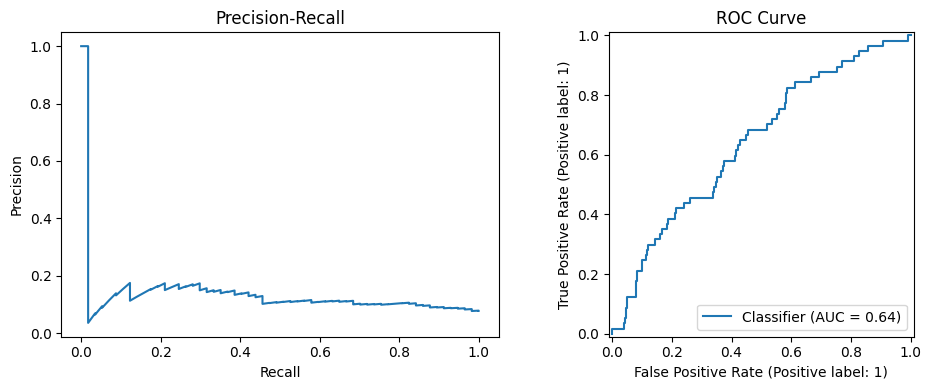

In [61]:
model.eval()
with torch.no_grad():
    logits = []
    labels = []
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        logits.append(model(batch_X).cpu())
        labels.append(batch_y)
    logits = torch.cat(logits)
    labels = torch.cat(labels)
    probs = torch.sigmoid(logits).numpy()
    labels_np = labels.numpy()

precision, recall, thresholds = precision_recall_curve(labels_np, probs)
f_scores = (2 * precision * recall) / np.clip(precision + recall, a_min=1e-8, a_max=None)
best_idx = np.argmax(f_scores)
best_threshold = thresholds[max(best_idx - 1, 0)] if best_idx < len(thresholds) else 0.5
preds = (probs >= best_threshold).astype(int)

print(f"Best threshold based on F1: {best_threshold:.3f}")
print(classification_report(labels_np, preds))
print('Test ROC-AUC:', roc_auc_score(labels_np, probs))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(recall, precision)
axes[0].set_title('Precision-Recall')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(labels_np, probs, ax=axes[1])
axes[1].set_title('ROC Curve')
plt.tight_layout()
plt.show()



In [ ]:
print('Best model weights saved to', data_dir / 'hive_cnn_torch.pt')
